In [1]:
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
from matplotlib import image
from matplotlib import pyplot
import numpy as np

from skimage import color
# from skimage import io

## Weighted Mask

The use of the standard categorical cross-entropy loss function in U-net can be problematic for biomedical image segmentation:  
* When using this loss function, the model is rewarded for classifying narrow cell boundaries as being in-cell pixels because they are close to many other in-cell pixels  
* While this might not reduce the overll accuracy much, it reduces the usefulness of the segmentation result  
* To mitigate this problem, the implementation from the paper includes a weight map that is used to add a weight value to the loss function.  

This weight map is calculated as follows:
<p align="center">
  <img height=80 src="weighted_map.png">
</p>  

$$ {w}_{c} = {class \, frequencies} $$
$$ {d}_{1} = {distance \,\,  to \,\, the \,\, nearest \,\, cell \,\, boundary} $$
* d_2 is the distance to the second nearest cell boundary  
* w_0 and sigma are   


(572, 572, 4)


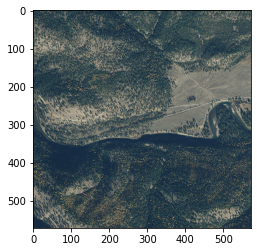

In [2]:
# import landcover image
image = plt.imread("NAIP17.png")
# image = np.mean(image, axis=2)

plt.imshow(image)

print(image.shape)

(572, 572)
<class 'torch.Tensor'>
torch.Size([572, 572])


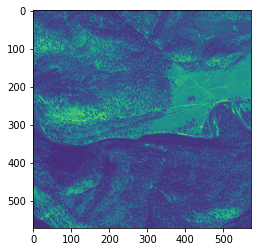

In [3]:
# imgOneBand = color.rgb2gray(image[:, :, :3])
imgOneBand = np.mean(image, axis=2)
plt.imshow(imgOneBand)
print(imgOneBand.shape)

imageTensor = torch.from_numpy(imgOneBand)
print(type(imageTensor))
print(imageTensor.size())

In [20]:
def double_conv(in_channel, out_channel):
    conv = nn.Sequential(
        nn.Conv2d(in_channel, out_channel, kernel_size=3), #3x3 convolutions
        nn.ReLU(inplace=True),
        nn.Conv2d(out_channel, out_channel, kernel_size=3),
        nn.ReLU(inplace=True),
    )
    return conv

def crop_img(tensor, target_tensor):
    target_size= target_tensor.size()[2]   # height?
    tensor_size = tensor.size()[2]
    delta = tensor_size - target_size      # tensor size larger because we're cropping 
    delta = delta // 2
    
    return tensor[:, :, delta:tensor_size-delta, delta:tensor_size-delta]  # all batches



class UNet(nn.Module):
    def __init__(self):
        super(UNet, self).__init__()

        # not learned
        self.max_pool_2x2 = nn.MaxPool2d(kernel_size=2, stride=2)

        # Five double convolutions
        self.down_conv_1 = double_conv(1, 64) # number of channels (input channels and output channels for the first step)
        self.down_conv_2 = double_conv(64, 128)
        self.down_conv_3 = double_conv(128, 256)
        self.down_conv_4 = double_conv(256, 512)
        self.down_conv_5 = double_conv(512, 1024)
        
        self.up_transpose_1 = nn.ConvTranspose2d(
            in_channels=1024, 
            out_channels=512, 
            kernel_size=2, 
            stride=2
        )
        self.up_conv_1 = double_conv(1024, 512)
        
        self.up_transpose_2 = nn.ConvTranspose2d(
            in_channels=512, 
            out_channels=256, 
            kernel_size=2, 
            stride=2
        )
        self.up_conv_2 = double_conv(512, 256)
    
        self.up_transpose_3 = nn.ConvTranspose2d(
            in_channels=256, 
            out_channels=128, 
            kernel_size=2, 
            stride=2
        )
        self.up_conv_3 = double_conv(256, 128)
        
        self.up_transpose_4 = nn.ConvTranspose2d(
            in_channels=128, 
            out_channels=64, 
            kernel_size=2, 
            stride=2
        )
        self.up_conv_4 = double_conv(128, 64)
        
        self.out = nn.Conv2d(
            in_channels=64, 
            out_channels=2, 
            kernel_size=1
        )
    
    def forward(self, image):
        '''
        batch size, channel, height, width
        '''
        
        #endocder
        x1 = self.down_conv_1(image)   # Skip Connection
        # print('x1:',x1.size()) # matches the paper
        x2 = self.max_pool_2x2(x1)
        # print('x2:',x2.size())
        x3 = self.down_conv_2(x2)      # Skip Connection
        # print('x3:',x3.size())
        x4 = self.max_pool_2x2(x3)
        # print('x4:',x4.size())
        x5 = self.down_conv_3(x4)      # Skip Connection
        # print('x5:',x5.size())
        x6 = self.max_pool_2x2(x5)
        # print('x6:',x6.size())
        x7 = self.down_conv_4(x6)      # Skip Connection
        # print('x7:',x7.size())
        x8 = self.max_pool_2x2(x7)
        # print('x8:',x8.size())
        x9 = self.down_conv_5(x8)
        # no max pooling in the u-net architecture here
        # print(f'x9: {x9.size()}\n')
        
        # decoder
        x = self.up_transpose_1(x9)
        # print(f'x: {x.size()}')
        
        # crop image
        y = crop_img(x7, x)
        # print(f'y: {y.size()}')
        
        # concatenate x with x7
        # print(f'x7: {x7.size()}')
        
        x = self.up_conv_1(torch.cat([x, y], 1))
        # print(f'x: {x.size()}')
        
        
        
        x = self.up_transpose_2(x) 
        # crop image
        y = crop_img(x5, x)
        #concatenate
        x = self.up_conv_2(torch.cat([x, y], 1))

        x = self.up_transpose_3(x) 
        # crop image
        y = crop_img(x3, x)
        #concatenate
        x = self.up_conv_3(torch.cat([x, y], 1))
        
        
        
        x = self.up_transpose_4(x) 
        # crop image
        y = crop_img(x1, x)
        #concatenate
        x = self.up_conv_4(torch.cat([x, y], 1))
 
        # print(f'x: {x.size()}')
    
    
        # add the output channel
        x = self.out(x)
        # print(f'x final: {x.size()}')
        
        return x
        


if __name__ == "__main__":
    
    # 572 x 572 
    image = torch.rand((1, 1, 572, 572))
    print('in:',image.shape)
    model = UNet()
    print(model)

in: torch.Size([1, 1, 572, 572])
UNet(
  (max_pool_2x2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (down_conv_1): Sequential(
    (0): Conv2d(1, 64, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_2): Sequential(
    (0): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_3): Sequential(
    (0): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_4): Sequential(
    (0): Conv2d(256, 512, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU(inplace=True)
    (2): Conv2d(512, 512, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU(inplace=True)
  )
  (down_conv_5): Sequential(
 

In [ ]:

learning_rate = 1e-4
loss_fn = nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

prediction = model(image)
loss = loss_fn(prediction, ground_truth)
optimizer.zero_grad()
